In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["LD_LIBRARY_PATH"]="/user/refspec"+os.environ["LD_LIBRARY_PATH"]
import lusee
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 3.5]
matplotlib.rcParams['figure.dpi'] = 100
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.integrate import simpson
import refspec
import os
print ('Refspec version: ', refspec.__version__)

Refspec version:  1.0


In [21]:
beam = lusee.Beam(os.environ['LUSEE_DRIVE_DIR']+"Simulations/BeamModels/LanderRegolithComparison/eight_layer_regolith/hfss_lbl_3m_75deg.2port.fits")
#f=np.logspace(-2,np.log10(50.),980
f = np.arange(98)*0.005+0.0010000000474974513
sky_frac_in = 1-beam.ground_fraction()
sky_frac_s = gaussian_filter(sky_frac_in,1)
sky_frac_s[0] = sky_frac_in[0]
sky_frac = interp1d(np.hstack((0,beam.freq)),np.hstack((0,sky_frac_s)),kind='quadratic')
T_sky = lusee.monosky.T_C(f).value
T_ant = sky_frac(f)*T_sky + ((1-sky_frac(f))*200)
T=lusee.Throughput(beam)

P_plasma = np.zeros_like(f)
P_plasma[f<10] = lusee.monosky.BalePlasmaEffects()(f[f<10])

T=lusee.Throughput(beam)
T.AntennaImpedanceInterp(np.array([0.1]))
P_sky_jfet = T_ant * T.T2Vsq(f)
P_plasma_jfet  = P_plasma*T.Gamma_VD(f)**2

gain = T.power_gain(f,'M')
P_sky_adc = P_sky_jfet * gain
P_plasma_adc = P_plasma_jfet * gain
P_noise_adc = T.noise(f) * gain * 2 # a factor of 2 due to two amplifiers
P_total_adc = P_sky_adc + P_plasma_adc + P_noise_adc


In [22]:
def measure  (f, P_input, Nsec=1.0, PF_amplitude=0.0006,  tone=None, seed=10, fname = None):

    cfg = refspec.SpecConfig()
    cfghelp = refspec.SpecConfigHelper(cfg)
    sampling_rate = cfg.sampling_rate
    block_size = cfg.Nfft ## irrelevant here
    Nsamples = int(Nsec*sampling_rate)
    Nblocks_gen = Nsamples//block_size+2*cfg.Ntaps
    Nchannels = 1
    cfg.Ntaps        = 4
    cfg.zoomin_st    = 0
    cfg.zoomin_en    = 5*4; # 500 kHz times 4 / 100kHz
    Nzoom = 5
    Nzoomtaps = Ntaps
    cfghelp.set_zoom(Nzoom,Nzoomtaps,wfun)
    

    cfg.Nchannels       = 1
    cfg.Average1Size    = 60
    cfg.Average2Size    = int(Nsec*cfg.sampling_rate/(cfg.Average1Size*cfg.Nfft))
    print (cfg.Average2Size)
    assert(cfg.Average2Size>0)
    fundamental         = cfg.fundamental_frequency()


    if tone is not None:
        source = refspec.SignalGenerator(block_size, Nchannels, Nblocks_gen, tone*1e3, sampling_rate, 100.,0.)
    else:
        if PF_amplitude>0:
            picket_fname = os.environ['REFSPEC_PATH']+'/data/samples/picket_fence_1024.txt'
            PF = refspec.CombSource(block_size, Nchannels, 1024, picket_fname, 1, PF_amplitude)
        if P_input is not None:
            PS = refspec.PowerSpecSource (f,P_input, sampling_rate, block_size, Nchannels, Nblocks_gen, False, False, seed, True)

        if PF_amplitude>0 and P_input is not None:
            source = refspec.SignalCombiner([PS, PF], True)
        elif PF_amplitude>0:
            source = PF
        else:
            source = PS
    

    if fname is not None:
        sink = refspec.FileStreamSink(source, fname, bit_level=1e-4,bits=16)
        sink.write_data(Nblocks_gen*block_size)

        nsource  = refspec.FileStreamSource(block_size, Nchannels, fname);
    else:
        nsource = source
    spectrometer = refspec.RefSpectrometer(nsource, cfg)
    
    output = refspec.SpecOutput(cfg)
    spectrometer.run(output)
    
    Pkout = np.array(output.get_avg_pspec_zoom(0))
    fout = fundamental/5*np.arange(0,len(Pkout))
    #fout, Pkout = None, None

    PkOutR = np.array(output.get_avg_pspec(0))
    foutR = fundamental*np.arange(0,len(PkOutR))

    return fout, Pkout,foutR,PkOutR



In [23]:
PF_amplitude = 2e-5
Nsec = 1.0
taps =[1,2,3,4,5,6]
win = [1,2,3,4]
Pk_list = []
cal_list = []
for pass_by_file in [True]:

    if pass_by_file:
        fname_fun = lambda fname: fname
        norm=1e8
    else:
        fname_fun = lambda fname: None
        norm=1
    for x in win:
        if x == 1:
            wfun = None
        if x == 2:
            wfun = np.hamming
        if x == 3:
            wfun = np.blackman
        if x == 4:
            wfun = np.hanning
        for i in taps:
            Ntaps = i
            fk,Pk_cal,fkr,Pkr_cal = measure(f, np.ones_like(P_total_adc), Nsec=Nsec, PF_amplitude=0)
            cal = np.array(list(Pk_cal[0:5])+[Pk_cal[5+i::5].mean() for i in range(5)]*(len(Pk_cal)//5-1))
            fk,Pk_PF,fkr,Pkr_PF = measure(f, None, Nsec=Nsec, PF_amplitude=PF_amplitude, fname=fname_fun('F.bin'))
            fk,Pk_PS,fkr,Pkr_PS = measure(f, P_total_adc, Nsec=Nsec, PF_amplitude=0.0,fname=fname_fun('Pk.bin'))
            fk,Pk,fkr,Pkr = measure(f, P_total_adc, Nsec=Nsec, PF_amplitude=PF_amplitude,fname=fname_fun('both.bin'))
            Pk_list.append(Pk)
            cal_list.append(cal)

416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
416
Read 102465536 records from F.bin
416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
Read 102465536 records from Pk.bin
416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
Read 102465536 records from both.bin
416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
416
Read 102465536 records from F.bin
416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
Read 102465536 records from Pk.bin
416
*** Planning 102465536 samples = 1.00064 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
Read 10246553

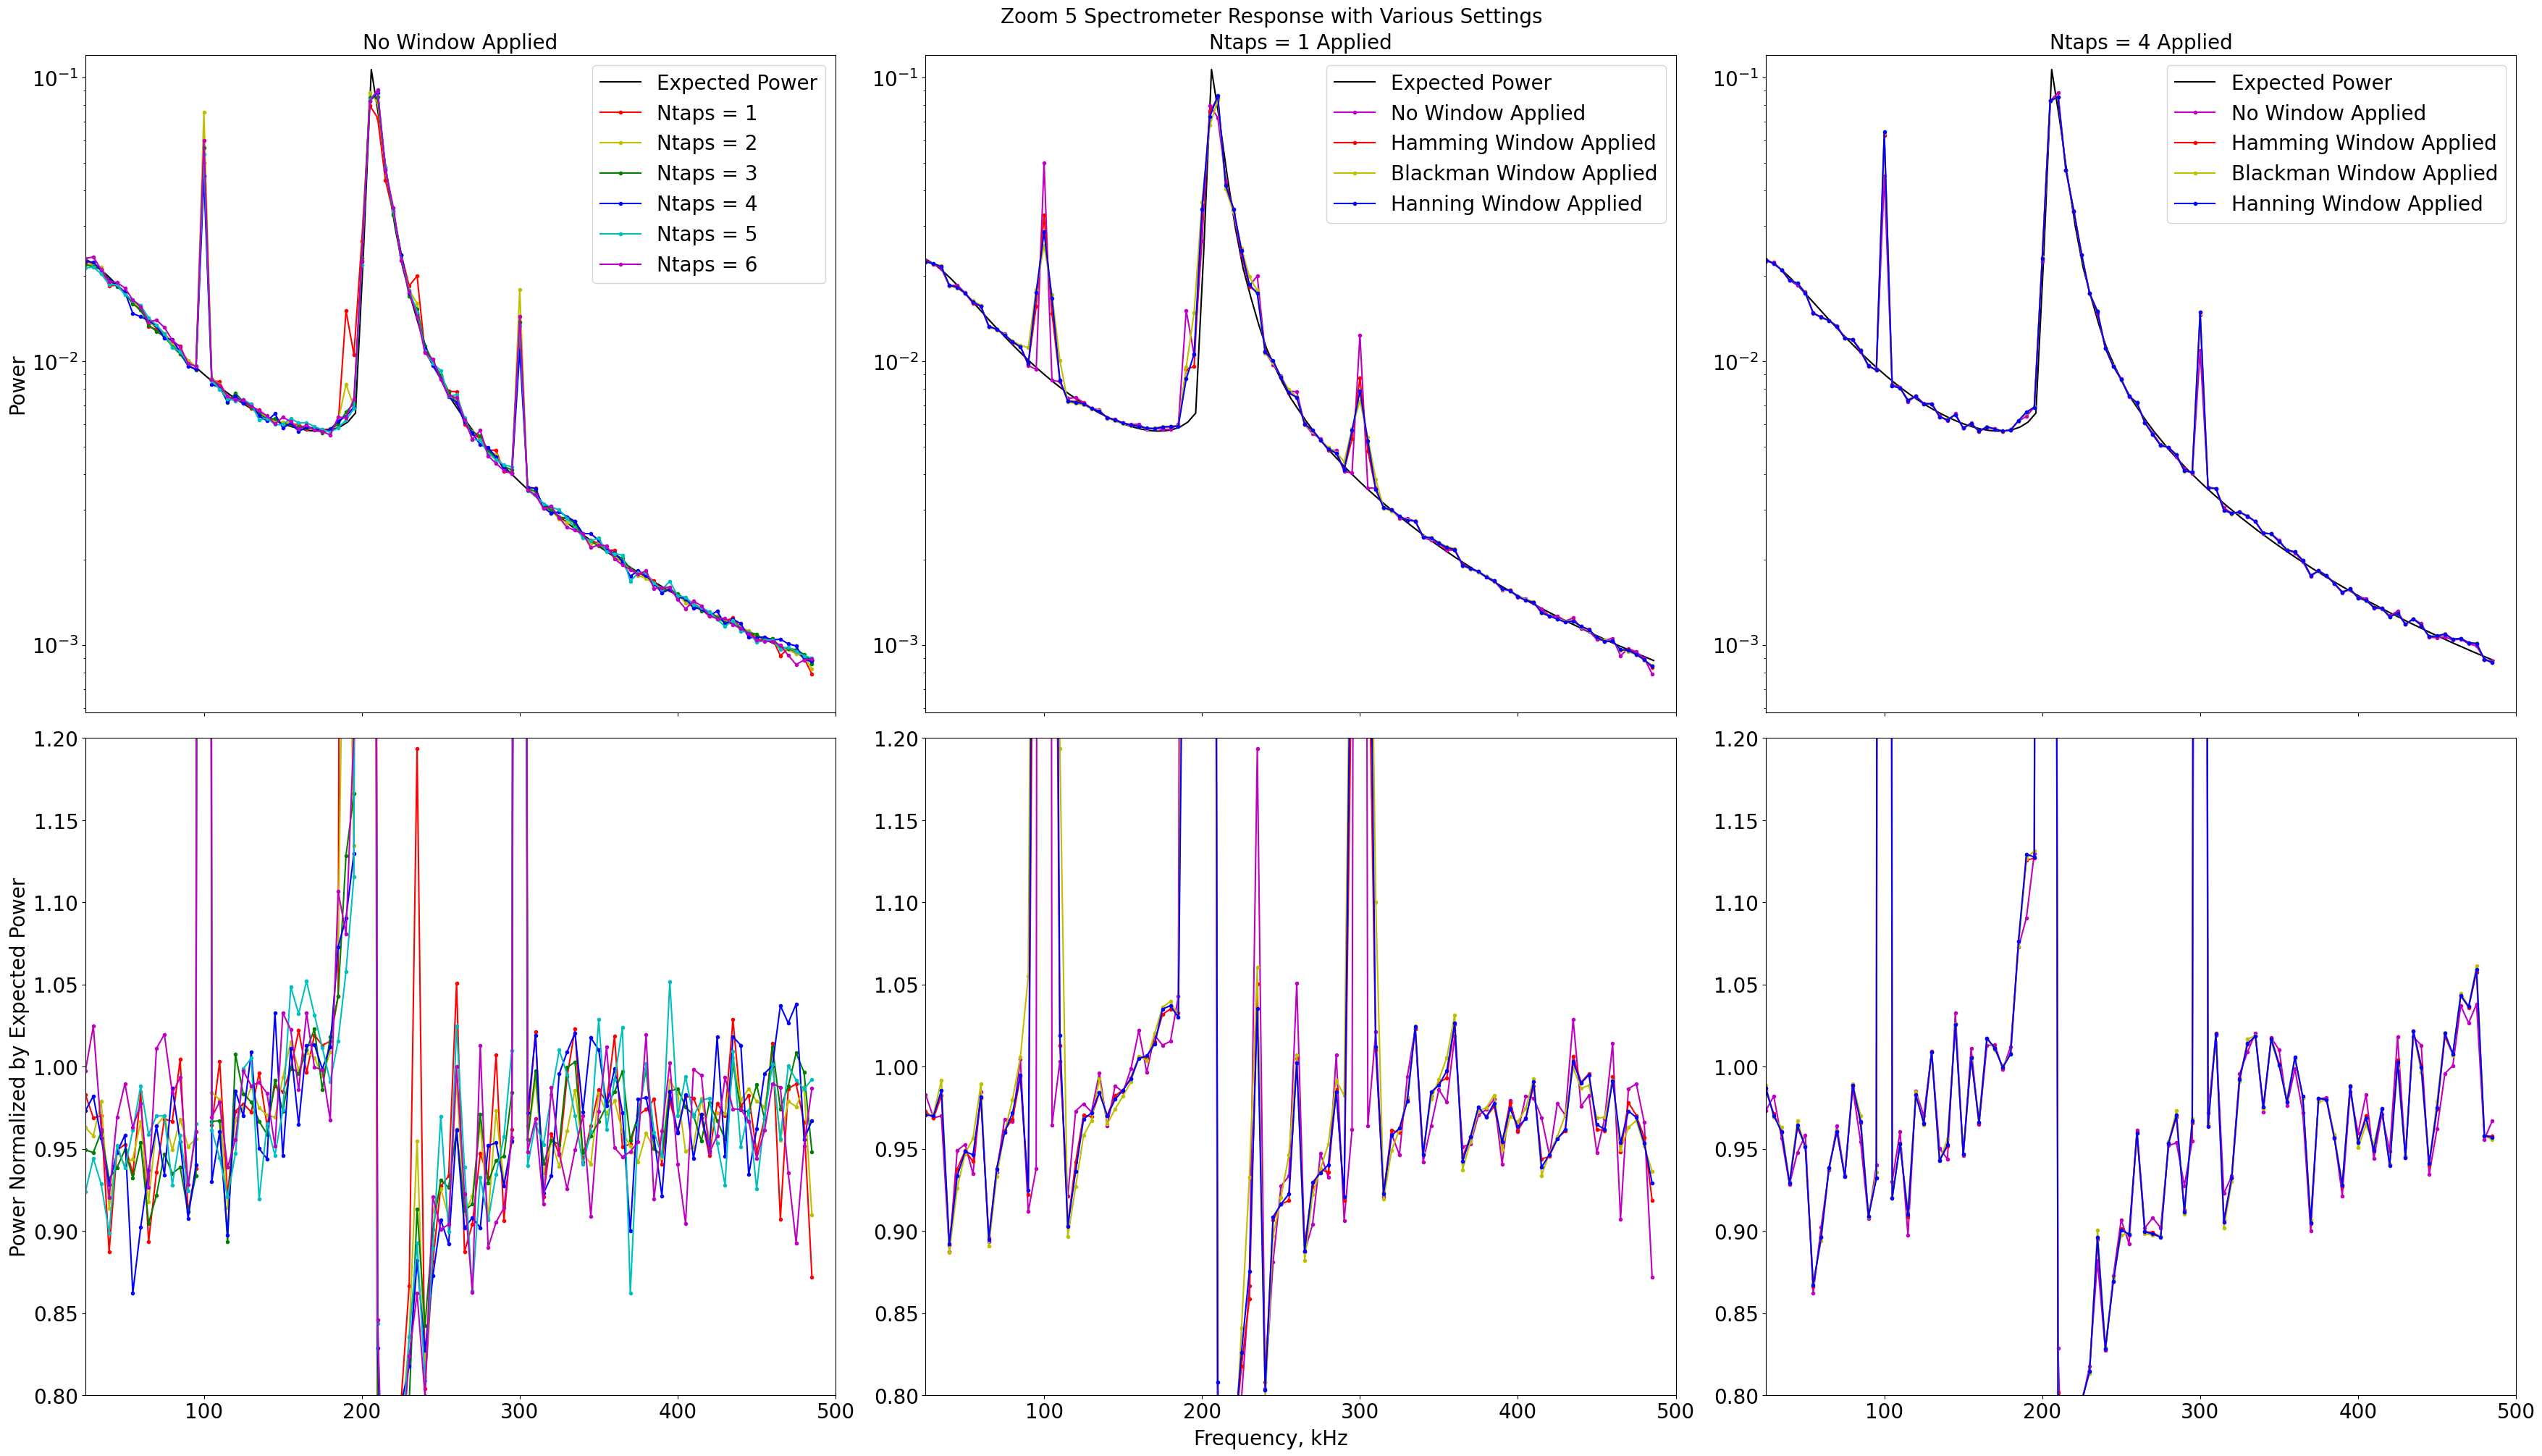

In [24]:
fig, axs = plt.subplots(2,3, figsize = (35,20), sharex=True, sharey=False, layout = 'constrained')
fig.suptitle('Zoom 5 Spectrometer Response with Various Settings', fontsize = 20)
fig.supxlabel('Frequency, kHz', fontsize = 20)
axs[0][0].set_title('No Window Applied', fontsize = 20)
axs[0][1].set_title('Ntaps = 1 Applied', fontsize = 20)
axs[0][2].set_title('Ntaps = 4 Applied', fontsize = 20)
axs[0][0].plot(f[:98]*1e3,(P_total_adc[:98]*norm),'k-',markersize=3, label = 'Expected Power')
axs[0][0].plot(fk[1:-2]/1e3,(Pk_list[0][3:]/cal_list[0][3:]),'ro-',markersize=3, label = 'Ntaps = 1')
axs[0][0].plot(fk[:-2]/1e3,(Pk_list[1][2:]/cal_list[1][2:]),'yo-',markersize=3, label = 'Ntaps = 2')
axs[0][0].plot(fk[:-2]/1e3,(Pk_list[2][2:]/cal_list[2][2:]),'go-',markersize=3, label = 'Ntaps = 3')
axs[0][0].plot(fk[1:-2]/1e3,(Pk_list[3][3:]/cal_list[3][3:]),'bo-',markersize=3, label = 'Ntaps = 4')
axs[0][0].plot(fk[:-2]/1e3,(Pk_list[4][2:]/cal_list[4][2:]),'co-',markersize=3, label = 'Ntaps = 5')
axs[0][0].plot(fk[:-2]/1e3,(Pk_list[5][2:]/cal_list[5][2:]),'mo-',markersize=3, label = 'Ntaps = 6')
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[0][3:]/cal_list[0][3:])/(P_total_adc[:97]*norm),'ro-',markersize=3)
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[1][3:]/cal_list[1][3:])/(P_total_adc[:97]*norm),'yo-',markersize=3)
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[2][3:]/cal_list[2][3:])/(P_total_adc[:97]*norm),'go-',markersize=3)
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[3][3:]/cal_list[3][3:])/(P_total_adc[:97]*norm),'bo-',markersize=3)
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[4][3:]/cal_list[4][3:])/(P_total_adc[:97]*norm),'co-',markersize=3)
axs[1][0].plot(fk[1:-2]/1e3,(Pk_list[5][3:]/cal_list[5][3:])/(P_total_adc[:97]*norm),'mo-',markersize=3)
axs[0][1].plot(f[:98]*1e3,(P_total_adc[:98]*norm),'k-',markersize=3, label = 'Expected Power')
axs[0][1].plot(fk[1:-2]/1e3,(Pk_list[0][3:]/cal_list[0][3:]),'mo-',markersize=3, label = 'No Window Applied')
axs[0][1].plot(fk[1:-2]/1e3,(Pk_list[6][3:]/cal_list[6][3:]),'ro-',markersize=3, label = 'Hamming Window Applied')
axs[0][1].plot(fk[1:-2]/1e3,(Pk_list[12][3:]/cal_list[12][3:]),'yo-',markersize=3, label = 'Blackman Window Applied')
axs[0][1].plot(fk[1:-2]/1e3,(Pk_list[18][3:]/cal_list[18][3:]),'bo-',markersize=3, label = 'Hanning Window Applied')
axs[1][1].plot(fk[1:-2]/1e3,(Pk_list[0][3:]/cal_list[0][3:])/(P_total_adc[:97]*norm),'mo-',markersize=3)
axs[1][1].plot(fk[1:-2]/1e3,(Pk_list[6][3:]/cal_list[6][3:])/(P_total_adc[:97]*norm),'ro-',markersize=3, label = 'Hamming Window Applied')
axs[1][1].plot(fk[1:-2]/1e3,(Pk_list[12][3:]/cal_list[12][3:])/(P_total_adc[:97]*norm),'yo-',markersize=3, label = 'Blackman Window Applied')
axs[1][1].plot(fk[1:-2]/1e3,(Pk_list[18][3:]/cal_list[18][3:])/(P_total_adc[:97]*norm),'bo-',markersize=3, label = 'Hanning Window Applied')
axs[0][2].plot(f[:98]*1e3,(P_total_adc[:98]*norm),'k-',markersize=3, label = 'Expected Power')
axs[0][2].plot(fk[1:-2]/1e3,(Pk_list[3][3:]/cal_list[3][3:]),'mo-',markersize=3, label = 'No Window Applied')
axs[0][2].plot(fk[1:-2]/1e3,(Pk_list[9][3:]/cal_list[9][3:]),'ro-',markersize=3, label = 'Hamming Window Applied')
axs[0][2].plot(fk[1:-2]/1e3,(Pk_list[15][3:]/cal_list[15][3:]),'yo-',markersize=3, label = 'Blackman Window Applied')
axs[0][2].plot(fk[1:-2]/1e3,(Pk_list[21][3:]/cal_list[21][3:]),'bo-',markersize=3, label = 'Hanning Window Applied')
axs[1][2].plot(fk[1:-2]/1e3,(Pk_list[3][3:]/cal_list[3][3:])/(P_total_adc[:97]*norm),'mo-',markersize=3)
axs[1][2].plot(fk[1:-2]/1e3,(Pk_list[9][3:]/cal_list[9][3:])/(P_total_adc[:97]*norm),'ro-',markersize=3, label = 'Hamming Window Applied')
axs[1][2].plot(fk[1:-2]/1e3,(Pk_list[15][3:]/cal_list[15][3:])/(P_total_adc[:97]*norm),'yo-',markersize=3, label = 'Blackman Window Applied')
axs[1][2].plot(fk[1:-2]/1e3,(Pk_list[21][3:]/cal_list[21][3:])/(P_total_adc[:97]*norm),'bo-',markersize=3, label = 'Hanning Window Applied')
axs[0][0].set_ylabel('Power', fontsize = 20)
axs[1][0].set_ylabel('Power Normalized by Expected Power', fontsize = 20)
axs[0][0].set_xlim(25,500)
axs[0][0].set_ylim(.00058, 0.12)
axs[0][1].set_ylim(.00058, 0.12)
axs[0][2].set_ylim(.00058, 0.12)
axs[0][0].set_yscale("log")
axs[0][1].set_yscale("log")
axs[0][2].set_yscale("log")
axs[1][0].set_xlim(25,500)
axs[1][0].set_ylim(.028, 5)
axs[1][0].set_ylim(.8, 1.2)
axs[1][1].set_ylim(.8, 1.2)
axs[1][2].set_ylim(.8, 1.2)
axs[0][0].legend(fontsize = 20)
axs[0][1].legend(fontsize = 20)
axs[0][2].legend(fontsize = 20)
axs[0][0].tick_params(axis='both', which='major', labelsize=20)
axs[0][1].tick_params(axis='both', which='major', labelsize=20)
axs[0][2].tick_params(axis='both', which='major', labelsize=20)
axs[1][0].tick_params(axis='both', which='major', labelsize=20)
axs[1][1].tick_params(axis='both', which='major', labelsize=20)
axs[1][2].tick_params(axis='both', which='major', labelsize=20)
#plt.savefig('zoom5_setting_comparison.png')